<a href="https://colab.research.google.com/github/Telemaco019/flower_recognition/blob/master/tf_flowers_complete_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [1]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [3]:
#!pip install kaggle
#!mkdir -p ~/.kaggle

!pip install efficientnet

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"bedb4989e91ea64f76f3a7460c7aaa1d"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"bedb4989e91ea64f76f3a7460c7aaa1d"}

In [8]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 441M/450M [00:06<00:00, 40.8MB/s]
100% 450M/450M [00:06<00:00, 68.0MB/s]


In [9]:
!unzip /content/flowers-recognition.zip 

Archive:  /content/flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.

# Constants and imports


In [2]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 

import efficientnet.tfkeras as efn 

Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0-rc1


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [7]:
(X,Y) = load_dataset()

  6%|▋         | 49/769 [00:00<00:01, 480.47it/s]

Loading data from: /content/flowers/daisy/


  4%|▍         | 46/1055 [00:00<00:02, 455.92it/s]

Loading data from: /content/flowers/dandelion/


  5%|▌         | 40/784 [00:00<00:01, 386.65it/s]

Loading data from: /content/flowers/rose/


  5%|▍         | 35/734 [00:00<00:02, 339.10it/s]

Loading data from: /content/flowers/sunflower/


100%|██████████| 734/734 [00:02<00:00, 362.99it/s]


In [8]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 3339
Total number of labels: 3339


**Split train, valid and test datasets**

In [9]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 2504
Validation dataset size: 626
Test dataset size: 209


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.figure() 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 
  plt.figure()

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plot_accuracy_curves(history)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [25]:
test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False)).prefetch(AUTOTUNE).batch(1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Take 1: feature extraction with GlobalMaxPooling


---



In [0]:
train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=True))
train_dataset = batch_and_prefetch(train_dataset)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

In [0]:
conv_base = efn.EfficientNetB0(weights="imagenet", include_top=False, pooling='max')

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

In [27]:
conv_base.input_shape

(None, None, None, 3)

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [38]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 6,405
Non-trainable params: 4,049,564
_________________________________________________________________


In [39]:
epochs = 50
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_take_1.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/50
78/78 [==============================] - 14s 176ms/step - loss: 3.0719 - accuracy: 0.2348 - val_loss: 3.1942 - val_accuracy: 0.2352
Epoch 2/50
78/78 [==============================] - 7s 95ms/step - loss: 2.6202 - accuracy: 0.2817 - val_loss: 2.7665 - val_accuracy: 0.2845
Epoch 3/50
78/78 [==============================] - 7s 95ms/step - loss: 2.3239 - accuracy: 0.3409 - val_loss: 2.4241 - val_accuracy: 0.3470
Epoch 4/50
78/78 [==============================] - 7s 95ms/step - loss: 2.0358 - accuracy: 0.4143 - val_loss: 2.1847 - val_accuracy: 0.3997
Epoch 5/50
78/78 [==============================] - 7s 94ms/step - loss: 1.8223 - accuracy: 0.4443 - val_loss: 1.9475 - val_accuracy: 0.4556
Epoch 6/50
78/78 [==============================] - 7s 95ms/step - loss: 1.7111 - accuracy: 0.4804 - val_loss: 1.77

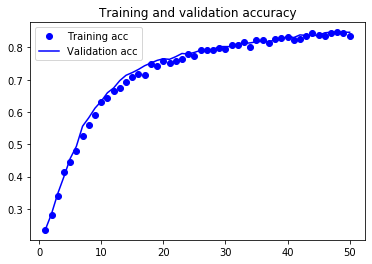

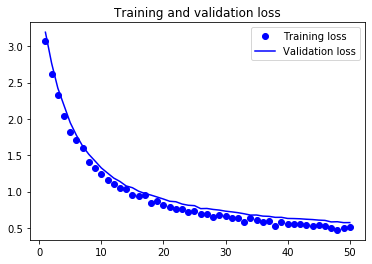

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.8421052631578947|0.8421052631578947|0.8421052631578947
|Macro|0.8387053892546894|0.8390730495123782|0.8386093367452807


In [40]:
plot_curves(history)
show_scores(model)

# Take 2: feature extraction with GlobalAvgPooling


In [42]:
conv_base = efn.EfficientNetB0(weights="imagenet", include_top=False, pooling='avg')

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [44]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 6,405
Non-trainable params: 4,049,564
_________________________________________________________________


In [45]:
epochs = 50
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_take_2.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/50
78/78 [==============================] - 13s 168ms/step - loss: 1.5532 - accuracy: 0.3221 - val_loss: 1.4473 - val_accuracy: 0.3964
Epoch 2/50
78/78 [==============================] - 8s 99ms/step - loss: 1.4225 - accuracy: 0.4599 - val_loss: 1.3297 - val_accuracy: 0.5329
Epoch 3/50
78/78 [==============================] - 8s 98ms/step - loss: 1.3136 - accuracy: 0.5645 - val_loss: 1.2249 - val_accuracy: 0.5839
Epoch 4/50
78/78 [==============================] - 8s 97ms/step - loss: 1.2163 - accuracy: 0.6294 - val_loss: 1.1325 - val_accuracy: 0.6711
Epoch 5/50
78/78 [==============================] - 7s 92ms/step - loss: 1.1341 - accuracy: 0.6711 - val_loss: 1.0522 - val_accuracy: 0.7237
Epoch 6/50
78/78 [==============================] - 7s 92ms/step - loss: 1.0572 - accuracy: 0.7196 - val_loss: 0.98

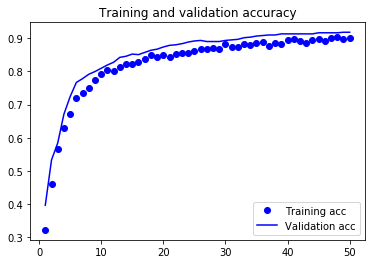

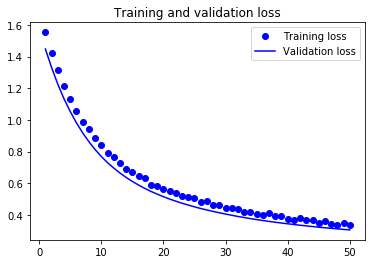

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.8803827751196173|0.8803827751196173|0.8803827751196173
|Macro|0.8828372877626609|0.8730240595863252|0.8763287165903445


In [46]:
plot_curves(history)
show_scores(model)

# Take 3: feature extraction with Dense hidden layer and GlobalAvgPooling

> Indented block




In [47]:
conv_base = efn.EfficientNetB0(weights="imagenet", include_top=False, pooling='avg')

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [49]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
Total params: 4,708,001
Trainable params: 658,437
Non-trainable params: 4,049,564
_________________________________________________________________


In [51]:
epochs = 50
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_take_3.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/50
78/78 [==============================] - 9s 120ms/step - loss: 0.9529 - accuracy: 0.7552 - val_loss: 0.7353 - val_accuracy: 0.8191
Epoch 2/50
78/78 [==============================] - 8s 99ms/step - loss: 0.6568 - accuracy: 0.8345 - val_loss: 0.5296 - val_accuracy: 0.8701
Epoch 3/50
78/78 [==============================] - 8s 100ms/step - loss: 0.5081 - accuracy: 0.8562 - val_loss: 0.4220 - val_accuracy: 0.8865
Epoch 4/50
78/78 [==============================] - 8s 99ms/step - loss: 0.4172 - accuracy: 0.8922 - val_loss: 0.3578 - val_accuracy: 0.8997
Epoch 5/50
78/78 [==============================] - 7s 95ms/step - loss: 0.3641 - accuracy: 0.8954 - val_loss: 0.3144 - val_accuracy: 0.9079
Epoch 6/50
78/78 [==============================] - 8s 97ms/step - loss: 0.3289 - accuracy: 0.8978 - val_loss: 0.28

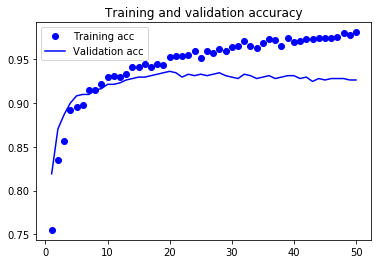

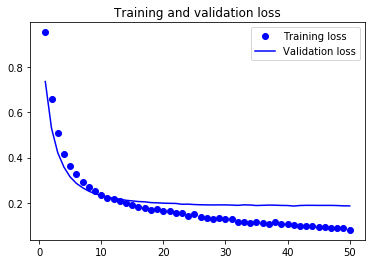

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.93|0.93|0.93
|Macro|0.93|0.92|0.92


In [60]:
plot_curves(history)
show_scores(model)

# Take 4: feature extraction with Dense hidden layer and GlobalMaxPooling

> Indented block




In [84]:
conv_base = efn.EfficientNetB0(weights="imagenet", include_top=False, pooling='max')

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [89]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_20 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 2565      
Total params: 4,708,001
Trainable params: 658,437
Non-trainable params: 4,049,564
_________________________________________________________________


In [90]:
epochs = 50
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_take_4.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/50
78/78 [==============================] - 15s 187ms/step - loss: 1.3146 - accuracy: 0.5569 - val_loss: 0.8157 - val_accuracy: 0.7286
Epoch 2/50
78/78 [==============================] - 8s 100ms/step - loss: 0.7163 - accuracy: 0.7528 - val_loss: 0.6194 - val_accuracy: 0.7977
Epoch 3/50
78/78 [==============================] - 8s 101ms/step - loss: 0.5443 - accuracy: 0.8245 - val_loss: 0.5148 - val_accuracy: 0.8454
Epoch 4/50
78/78 [==============================] - 8s 102ms/step - loss: 0.4545 - accuracy: 0.8502 - val_loss: 0.4674 - val_accuracy: 0.8553
Epoch 5/50
78/78 [==============================] - 8s 97ms/step - loss: 0.4307 - accuracy: 0.8554 - val_loss: 0.4410 - val_accuracy: 0.8701
Epoch 6/50
78/78 [==============================] - 7s 94ms/step - loss: 0.3990 - accuracy: 0.8594 - val_loss: 0

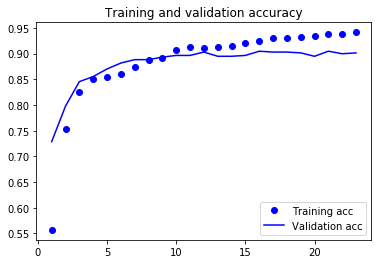

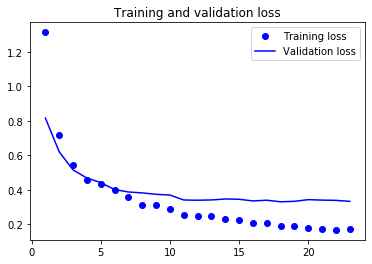

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.88|0.88|0.88


In [91]:
plot_curves(history)
show_scores(model)

# Take 5: traning from scratch

In [96]:
conv_base = efn.EfficientNetB0(include_top=False, pooling='max')
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [98]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [99]:
epochs = 50
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_take_5.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/50
78/78 [==============================] - 31s 398ms/step - loss: 2.8012 - accuracy: 0.3922 - val_loss: 1.5919 - val_accuracy: 0.6069
Epoch 2/50
78/78 [==============================] - 18s 225ms/step - loss: 1.3907 - accuracy: 0.6234 - val_loss: 1.0675 - val_accuracy: 0.7401
Epoch 3/50
78/78 [==============================] - 18s 227ms/step - loss: 0.9138 - accuracy: 0.7452 - val_loss: 0.8666 - val_accuracy: 0.7911
Epoch 4/50
78/78 [==============================] - 18s 228ms/step - loss: 0.7261 - accuracy: 0.7873 - val_loss: 0.7325 - val_accuracy: 0.8191
Epoch 5/50
78/78 [==============================] - 18s 226ms/step - loss: 0.5548 - accuracy: 0.8305 - val_loss: 0.6529 - val_accuracy: 0.8257
Epoch 6/50
78/78 [==============================] - 18s 227ms/step - loss: 0.5220 - accuracy: 0.8393 - val_

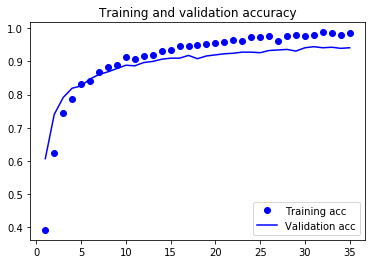

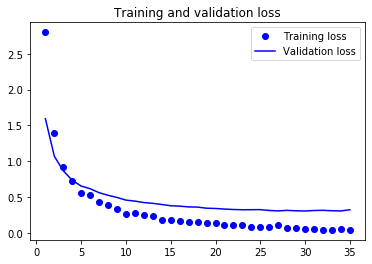

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.91|0.91|0.91
|Macro|0.92|0.91|0.91


In [100]:
plot_curves(history)
show_scores(model)

# Take 6: fine tuning

In [171]:
conv_base = efn.EfficientNetB0(weights='imagenet', include_top=False, pooling='max')

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_17[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [173]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 6,405
Non-trainable params: 4,049,564
_________________________________________________________________


**Few epochs of training with high learning rate and all weights of the convolutional base frozen, in order to train the last Dense layer**

In [174]:
epochs = 6
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_take_6.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/6
78/78 [==============================] - 19s 248ms/step - loss: 1.4006 - accuracy: 0.6478 - val_loss: 0.7461 - val_accuracy: 0.8224
Epoch 2/6
78/78 [==============================] - 7s 92ms/step - loss: 0.6851 - accuracy: 0.8069 - val_loss: 0.7382 - val_accuracy: 0.8289
Epoch 3/6
78/78 [==============================] - 7s 91ms/step - loss: 0.5253 - accuracy: 0.8554 - val_loss: 0.4800 - val_accuracy: 0.8799
Epoch 4/6
78/78 [==============================] - 7s 84ms/step - loss: 0.4450 - accuracy: 0.8722 - val_loss: 0.5098 - val_accuracy: 0.8832
Epoch 5/6
78/78 [==============================] - 7s 93ms/step - loss: 0.4329 - accuracy: 0.8818 - val_loss: 0.4572 - val_accuracy: 0.9062
Epoch 6/6
78/78 [==============================] - 6s 78ms/step - loss: 0.3589 - accuracy: 0.8962 - val_loss: 0.5359 - v

**Unfreeze the last layers and train again with lower learning rate**

In [0]:
for layer in conv_base.layers:
  if layer.name.startswith('block7'):
    layer.trainable = True

In [176]:
optimizer = RMSprop(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 723,637
Non-trainable params: 3,332,332
_________________________________________________________________


In [177]:
epochs = 60
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_take_6.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 2504 - Training steps per epoch: 78
Validation dataset size: 626 - Validation steps per epoch: 78
Train for 78 steps, validate for 19 steps
Epoch 1/60
78/78 [==============================] - 13s 166ms/step - loss: 0.5602 - accuracy: 0.8486 - val_loss: 0.4814 - val_accuracy: 0.8914
Epoch 2/60
78/78 [==============================] - 7s 90ms/step - loss: 0.4840 - accuracy: 0.8678 - val_loss: 0.5123 - val_accuracy: 0.8783
Epoch 3/60
78/78 [==============================] - 7s 87ms/step - loss: 0.4538 - accuracy: 0.8650 - val_loss: 0.5293 - val_accuracy: 0.8783
Epoch 4/60
78/78 [==============================] - 7s 86ms/step - loss: 0.3757 - accuracy: 0.8874 - val_loss: 0.5280 - val_accuracy: 0.8799
Epoch 5/60
78/78 [==============================] - 7s 84ms/step - loss: 0.3669 - accuracy: 0.9006 - val_loss: 0.5208 - val_accuracy: 0.8799
Epoch 6/60
78/78 [==============================] - 7s 88ms/step - loss: 0.3773 - accuracy: 0.8926 - val_loss: 0.51

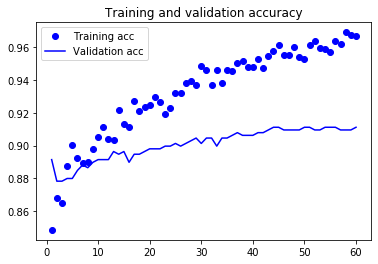

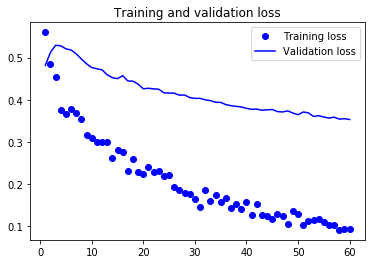

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.91|0.91|0.91
|Macro|0.91|0.91|0.91


In [178]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 190 out of 209


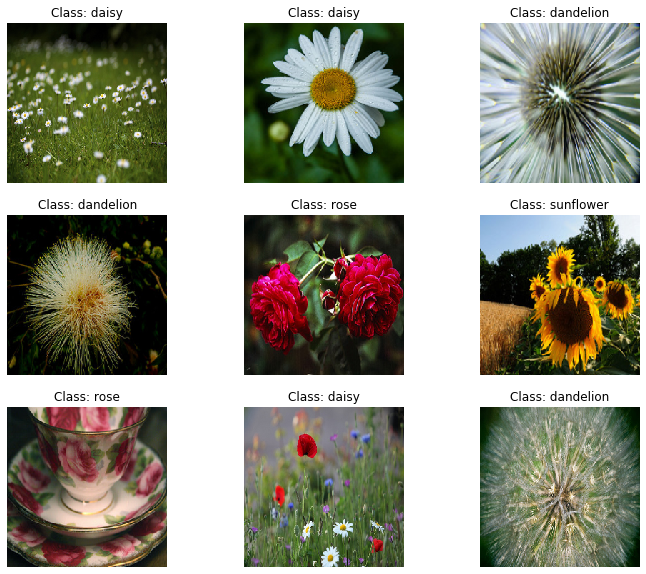

In [179]:
plot_correct_predictions(model)

Wrong predictions: 18 out of 209


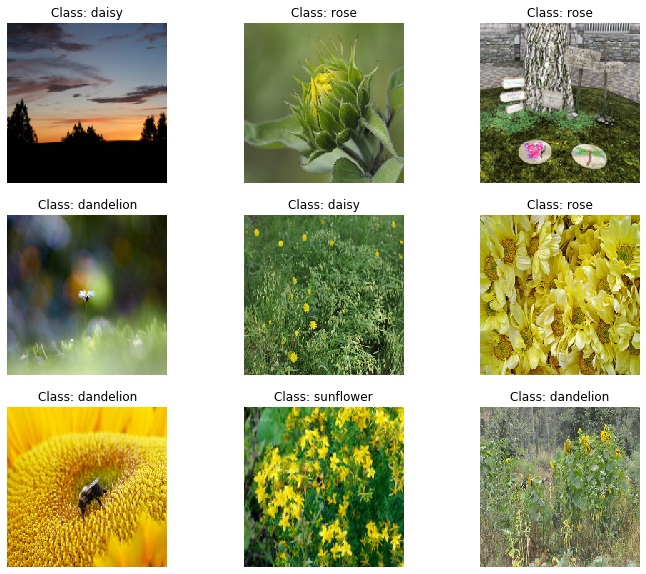

In [102]:
plot_wrong_predictions(model)